In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
plt.style.use('ggplot') # Lets make our plots pretty

path = os.getcwd()

print(path)  

/Users/owner/Desktop/kaggle_elo/Models


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Read in the dataframes
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
merchants = pd.read_csv('../input/merchants.csv')
new_merchants = pd.read_csv('../input/new_merchant_transactions.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

def datetime_extract(df, dt_col='first_active_month'):
    # df['date'] = df[dt_col].dt.date 
    df['day'] = df[dt_col].dt.day 
    df['dayofweek'] = df[dt_col].dt.dayofweek
    df['dayofyear'] = df[dt_col].dt.dayofyear
    df['days_in_month'] = df[dt_col].dt.days_in_month
    df['daysinmonth'] = df[dt_col].dt.daysinmonth 
    df['month'] = df[dt_col].dt.month
    df['week'] = df[dt_col].dt.week 
    df['weekday'] = df[dt_col].dt.weekday
    df['weekofyear'] = df[dt_col].dt.weekofyear
    # df['year'] = train[dt_col].dt.year

    return df

    for df in [train, test, merchants, historical_transactions, new_merchant_transactions]:
        missing_impute(df)

In [4]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size', 'median']
}
'''
grouped = new_merchant_transactions.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount",
    "median": "median_purchase_amount"
}, inplace=True)
grouped.reset_index(inplace=True)
'''
#train = pd.merge(train, grouped, on="card_id", how="left")
#test = pd.merge(test, grouped, on="card_id", how="left")


# One-hot encode features
ohe_df_1 = pd.get_dummies(train['feature_1'], prefix='f1_')
ohe_df_2 = pd.get_dummies(train['feature_2'], prefix='f2_')
ohe_df_3 = pd.get_dummies(train['feature_3'], prefix='f3_')

ohe_df_4 = pd.get_dummies(test['feature_1'], prefix='f1_')
ohe_df_5 = pd.get_dummies(test['feature_2'], prefix='f2_')
ohe_df_6 = pd.get_dummies(test['feature_3'], prefix='f3_')

# Numerical representation of the first active month
train = pd.concat([train, ohe_df_1, ohe_df_2, ohe_df_3], axis=1, sort=False)
test = pd.concat([test, ohe_df_4, ohe_df_5, ohe_df_6], axis=1, sort=False)

del ohe_df_1, ohe_df_2, ohe_df_3
del ohe_df_4, ohe_df_5, ohe_df_6
#gc.collect()

excluded_features = ['first_active_month', 'card_id', 'target', 'date']
train_features = [c for c in train.columns if c not in excluded_features]

# Prepare data for training
X = train.copy()
y = X['target']

In [5]:
# Split data with kfold
kfolds = KFold(n_splits=10, shuffle=True, random_state=6532)

# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X[train_features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[train_features].iloc[val_idx], y.iloc[val_idx]
    
    # LightGBM Regressor estimator
    model = lgb.LGBMRegressor(
    num_leaves=40,
     boosting_type='dart'
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=None, eval_metric='rmse',
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.booster_.feature_importance(importance_type='gain')
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)
    test_preds = model.predict(test[train_features], num_iteration=model.best_iteration_)
    sub_preds += test_preds / kfolds.n_splits
    
mean_squared_error(y, oof_preds) ** .5

3.85335218170828

In [6]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

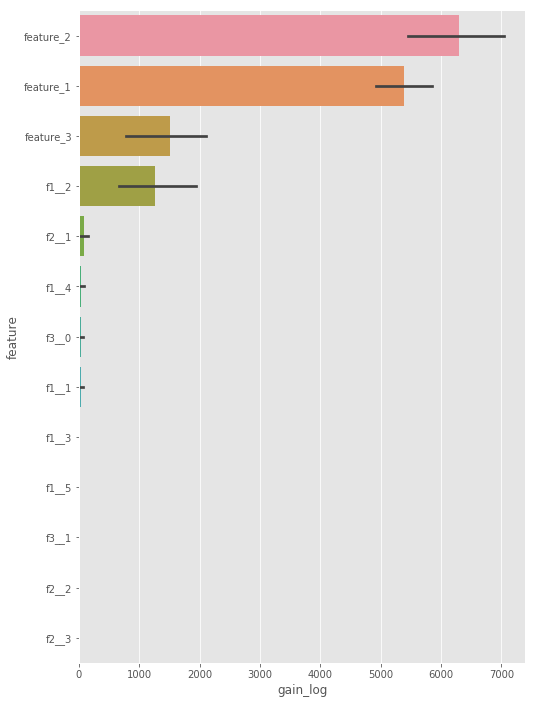

In [7]:
plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))